<a href="https://colab.research.google.com/github/CitricAmoeba/INT2-Group2/blob/main/CIFAR10_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [15]:
batch_size = 32

# Composition of several image transformations to perform on the training data
train_transform = transforms.Compose([
                                transforms.RandomCrop(32, 4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(0.2, 0.2),
                                transforms.RandomAffine(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
                                ])

# Normalization mean and std calculated from: trainset.data.mean(axis=(0,1,2))/255 and trainset.data.std(axis=(0,1,2))/255


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # 50000 images

# Testing data normalization
test_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.494, 0.485, 0.450), (0.247, 0.243, 0.261))
                                    ])
# Normalization mean and std calculated from: testset.data.mean(axis=(0,1,2))/255 and testset.data.std(axis=(0,1,2))/255

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # 10000 images

classes = trainset.classes # Categories of images

accuracy0 = [] # Cyclic
avg_loss0 = []
lrs = []
#lr_loss = []

accuracy1 = [] # 1e-2
avg_loss1 = []

accuracy2 = [] # 5e-3
avg_loss2 = []

accuracy3 = [] # 1e-3
avg_loss3 = []

accuracy4 = [] # 5e-4
avg_loss4 = []

accuracy5 = [] # 1e-4
avg_loss5 = []

Files already downloaded and verified
Files already downloaded and verified


In [16]:
!nvidia-smi -L
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8152bdee-a980-6d33-1f6d-40057e689b1e)
Using cuda device


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 200, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(200, 256, 5)
        self.dropout1 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = x.view(-1, 256 * 5 * 5)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x


net = Net()
net.to(device)

print(net)

Net(
  (conv1): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(200, 256, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=5e-3, momentum=0.9)
step_size = len(trainloader.dataset) // batch_size * 10
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=step_size, mode='triangular2') # ---

# Use to determine base and max lr
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=5e-2, step_size_up=62500)

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # scheduler.step() # ----
        lr = optimizer.param_groups[0]['lr']
        # lr_loss.append([lr, loss])
        lrs.append(lr)
        momentum = optimizer.param_groups[0]['momentum']
        
        if batch % (len(dataloader) // 5) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] lr: {lr:.8f} momentum: {momentum:.5f}")

In [20]:
def test(dataloader, model, accuracy, avg_loss):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accuracy.append(100*correct)
    avg_loss.append(test_loss)

In [21]:
epochs = 35

print("Cyclic LR")
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
    test(testloader, net, accuracy0, avg_loss0)

print("Done!")

Cyclic LR
Epoch 1
-------------------------------
loss: 2.301810  [    0/50000] lr: 0.00001064 momentum: 0.89999
loss: 2.273674  [ 9984/50000] lr: 0.00021018 momentum: 0.89800
loss: 2.179183  [19968/50000] lr: 0.00040973 momentum: 0.89600
loss: 1.963977  [29952/50000] lr: 0.00060927 momentum: 0.89400
loss: 2.076302  [39936/50000] lr: 0.00080882 momentum: 0.89200
loss: 1.828802  [49920/50000] lr: 0.00100836 momentum: 0.89001
Test Error: 
 Accuracy: 34.5%, Avg loss: 0.054783 

Epoch 2
-------------------------------
loss: 1.710951  [    0/50000] lr: 0.00101028 momentum: 0.88999
loss: 1.965017  [ 9984/50000] lr: 0.00120982 momentum: 0.88799
loss: 1.516547  [19968/50000] lr: 0.00140937 momentum: 0.88599
loss: 1.677339  [29952/50000] lr: 0.00160891 momentum: 0.88399
loss: 1.501204  [39936/50000] lr: 0.00180846 momentum: 0.88200
loss: 1.603466  [49920/50000] lr: 0.00200800 momentum: 0.88000
Test Error: 
 Accuracy: 47.6%, Avg loss: 0.045172 

Epoch 3
-------------------------------
loss: 1.60

In [31]:
epochs = 35

print("1e-3")
net = Net()
net.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
    test(testloader, net, accuracy3, avg_loss3)

print("Done!")

1e-3
Epoch 1
-------------------------------
loss: 2.304403  [    0/50000] lr: 0.00100000 momentum: 0.90000
loss: 2.164471  [ 9984/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.947175  [19968/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.782174  [29952/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.685297  [39936/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.539490  [49920/50000] lr: 0.00100000 momentum: 0.90000
Test Error: 
 Accuracy: 44.0%, Avg loss: 0.048564 

Epoch 2
-------------------------------
loss: 1.626690  [    0/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.375759  [ 9984/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.609060  [19968/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.329104  [29952/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.412148  [39936/50000] lr: 0.00100000 momentum: 0.90000
loss: 1.580368  [49920/50000] lr: 0.00100000 momentum: 0.90000
Test Error: 
 Accuracy: 51.4%, Avg loss: 0.042295 

Epoch 3
-------------------------------
loss: 1.628594 

In [32]:
epochs = 35

print("5e-4")
net = Net()
net.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=5e-4, momentum=0.9)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
    test(testloader, net, accuracy4, avg_loss4)

print("Done!")

5e-4
Epoch 1
-------------------------------
loss: 2.304755  [    0/50000] lr: 0.00050000 momentum: 0.90000
loss: 2.224149  [ 9984/50000] lr: 0.00050000 momentum: 0.90000
loss: 2.026050  [19968/50000] lr: 0.00050000 momentum: 0.90000
loss: 1.981968  [29952/50000] lr: 0.00050000 momentum: 0.90000
loss: 1.910424  [39936/50000] lr: 0.00050000 momentum: 0.90000
loss: 1.910307  [49920/50000] lr: 0.00050000 momentum: 0.90000
Test Error: 
 Accuracy: 38.7%, Avg loss: 0.054197 

Epoch 2
-------------------------------
loss: 1.740274  [    0/50000] lr: 0.00050000 momentum: 0.90000
loss: 1.790822  [ 9984/50000] lr: 0.00050000 momentum: 0.90000
loss: 1.803265  [19968/50000] lr: 0.00050000 momentum: 0.90000
loss: 1.675602  [29952/50000] lr: 0.00050000 momentum: 0.90000
loss: 1.566431  [39936/50000] lr: 0.00050000 momentum: 0.90000
loss: 1.801917  [49920/50000] lr: 0.00050000 momentum: 0.90000
Test Error: 
 Accuracy: 45.4%, Avg loss: 0.047519 

Epoch 3
-------------------------------
loss: 1.458833 

In [33]:
epochs = 35

print("1e-4")
net = Net()
net.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
    test(testloader, net, accuracy5, avg_loss5)

print("Done!")

1e-4
Epoch 1
-------------------------------
loss: 2.316884  [    0/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.306193  [ 9984/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.281496  [19968/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.270705  [29952/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.222642  [39936/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.200526  [49920/50000] lr: 0.00010000 momentum: 0.90000
Test Error: 
 Accuracy: 24.6%, Avg loss: 0.068502 

Epoch 2
-------------------------------
loss: 2.204721  [    0/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.191498  [ 9984/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.099991  [19968/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.106263  [29952/50000] lr: 0.00010000 momentum: 0.90000
loss: 1.994809  [39936/50000] lr: 0.00010000 momentum: 0.90000
loss: 2.024666  [49920/50000] lr: 0.00010000 momentum: 0.90000
Test Error: 
 Accuracy: 30.0%, Avg loss: 0.061555 

Epoch 3
-------------------------------
loss: 2.079746 

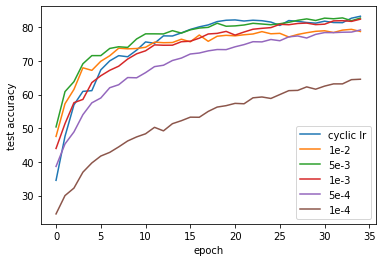

In [45]:
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.plot(list(range(len(accuracy0))), accuracy0, label='cyclic lr')
plt.plot(list(range(len(accuracy1))), accuracy1, label='1e-2')
plt.plot(list(range(len(accuracy2))), accuracy2, label='5e-3')
plt.plot(list(range(len(accuracy3))), accuracy3, label='1e-3')
plt.plot(list(range(len(accuracy4))), accuracy4, label='5e-4')
plt.plot(list(range(len(accuracy5))), accuracy5, label='1e-4')
plt.legend()
plt.savefig('cyclic-vs-fixed.svg')
plt.show()

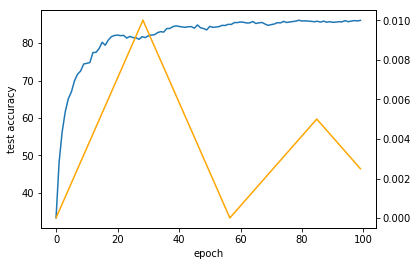

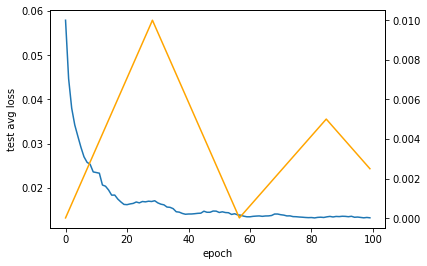

In [92]:
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.plot(list(range(len(accuracy))), accuracy)
plt.twinx()
plt.twiny()
plt.xticks([])
plt.ylabel('learning rate')
plt.plot(list(range(len(lrs))), lrs, color='orange')

plt.figure()
plt.xlabel('epoch')
plt.ylabel('test avg loss')
plt.plot(list(range(len(avg_loss))), avg_loss)
plt.twinx()
plt.twiny()
plt.xticks([])
plt.ylabel('learning rate')
plt.plot(list(range(len(lrs))), lrs, color='orange')
plt.show()


In [93]:
# Plot learning rate against loss for cyclic lr parameter determination
# plt.xlabel('learning rate')
# plt.ylabel('loss')
# plt.ylim(0, 4)

#plt.plot(np.array(lr_loss)[:, 0], np.array(lr_loss)[:, 1])

In [94]:
# Calculate class breakdown of accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
confusion_matrix = torch.zeros(len(testset.classes), len(testset.classes))
with torch.no_grad():
    net.eval()
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == y).squeeze()
        for t, p in zip(y.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        for i in range(16):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print(f'Accuracy of {classes[i]:10s} : {(100 * class_correct[i] / class_total[i]):.0f}%')

Accuracy of airplane   : 90%
Accuracy of automobile : 91%
Accuracy of bird       : 77%
Accuracy of cat        : 61%
Accuracy of deer       : 83%
Accuracy of dog        : 69%
Accuracy of frog       : 85%
Accuracy of horse      : 88%
Accuracy of ship       : 94%
Accuracy of truck      : 84%


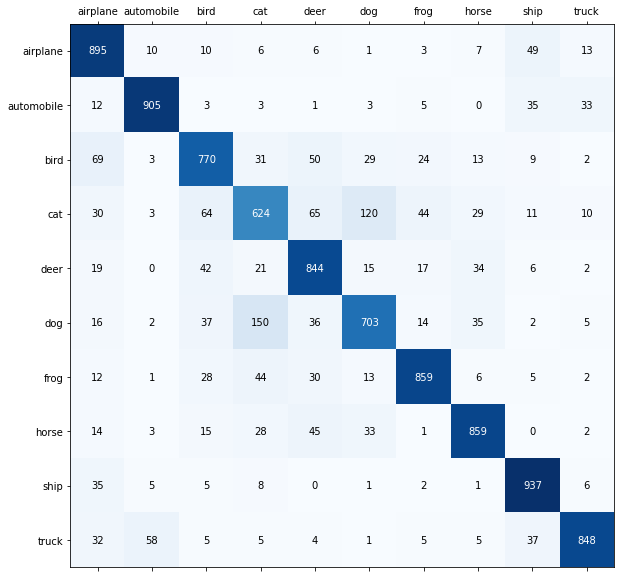

In [95]:
# Plot confusion matrix
fig, ax = plt.subplots()

ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.set_size_inches(10, 10)

plt.xticks(range(len(testset.classes)), testset.classes)
plt.yticks(range(len(testset.classes)), testset.classes)

for i in range(10):
    for j in range(10):
        c = confusion_matrix[j, i]
        ax.text(i, j, str(int(c)), va='center', ha='center', c='w' if c > 500 else 'k')
fig.savefig('confusion_matrix.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:220: UserWarning: ONNX export failed on feature_dropout because training mode not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


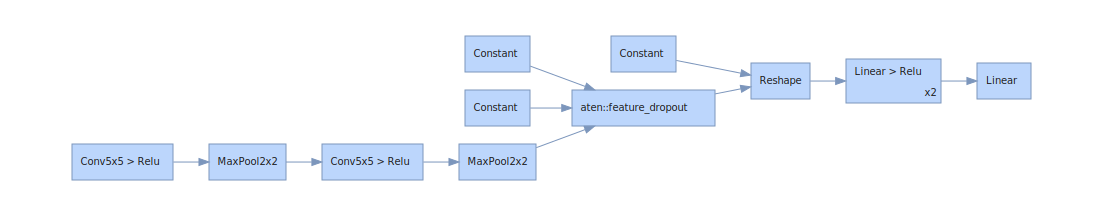

In [96]:
!pip install hiddenlayer
import hiddenlayer as hl

net.train()
hl_graph = hl.build_graph(net, torch.zeros([1, 3, 32, 32]).to(device))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph